The material in this notebook follows part 5 of Andrej Karpathy's stellar Makemore tutorial (https://www.youtube.com/watch?v=t3YJ5hKiMQ0)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

!git clone https://github.com/karpathy/makemore

Cloning into 'makemore'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 64 (delta 16), reused 14 (delta 14), pack-reused 47
Unpacking objects: 100% (64/64), done.


In [2]:
with open('makemore/names.txt','r') as file:
  words = file.read().splitlines()

In [3]:
word_lengths = torch.tensor([len(w) for w in words]).float()
print(
 f"""
 This dataset contains {word_lengths.nelement()} names\n
 The minimum name length is {word_lengths.min()} characters.\n 
 The maximum name length is {word_lengths.max()} characters.\n
 The mean name length is  {word_lengths.mean():.2f} characters. \n
 The associated standard deviation is {word_lengths.std():.2f} characters.
 """
 )


 This dataset contains 32033 names

 The minimum name length is 2.0 characters.
 
 The maximum name length is 15.0 characters.

 The mean name length is  6.12 characters. 

 The associated standard deviation is 1.44 characters.
 


In [4]:
#building the character vocabulary and lookup tables to map from characters to integer indices and back

chars = ['.']+sorted(list(set(''.join(words))))  #as before, '.' is used as a start/stop/padding special character
s_to_i = {s:i for i,s in enumerate(chars)}
i_to_s = {i:s for s,i in s_to_i.items()}
vocab_size = len(i_to_s)
print(i_to_s)
print(vocab_size)


{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27


In [5]:
import random
random.seed(42)
random.shuffle(words)

In [6]:
block_size = 8 #context length, size of the block that supports the prediction: P(x_n| x_{n-1}, x_{n-2}, x_{n-3} )

def build_dataset(words):
  X,Y = [], []

  for w in words:
    #print(w)
    context = [0] * block_size #init context using indices of chars
    for ch in w+'.':
      ix = s_to_i[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(i_to_s[i] for i in context), '--->', i_to_s[ix]) #context ---> current, training pattern
      context = context[1:]+[ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)
  return X,Y

#training split (used to train parameters), dev/validation split (used to train hyperparameters), test split (at end with the final model)
# 80%, 10%, 10%

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [7]:
## For understanding, let's take a look at how we have engineered our dataset
for x,y in zip(Xtr[:22], Ytr[:22]):
  print(''.join(i_to_s[ix.item()] for ix in x), '--->', i_to_s[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e
...xavie ---> n
..xavien ---> .


In [57]:
################################################################################
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out = x@self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight]+([] if self.bias is None else [self.bias])

################################################################################
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True 
    #parameters to be trained via backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # running buffers
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self,x):
    #forward pass
    if self.training:
      if x.ndim == 2:
        dim=0
      elif x.ndim == 3:
        dim=(0,1)
      xmean = x.mean(dim, keepdim=True)
      xvar = x.var(dim, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x-xmean)/ torch.sqrt(xvar+self.eps)
    self.out = self.gamma * xhat +self.beta
    #buffer update
    if self.training:
      with torch.no_grad():
        # exponential moving averages
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

################################################################################
class Tanh:
  
  def __call__(self,x):
    self.out = torch.tanh(x)
    return self.out
  
  def parameters(self):
    return []

################################################################################
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
  
  def __call__(self, X):
    self.out = self.weight[X]
    return self.out

  def parameters(self):
    return [self.weight]
  
################################################################################
class Flatten:

  def __call__(self, x):
    self.out = x.view(x.shape[0],-1) #flattens tensor to matrix
    return self.out

  def parameters(self):
    return [] 

class FlattenConsecutive:

  def __init__(self,n):
    self.n = n 

  def __call__(self, x):
    #recall x is (batch_size, block_size, embedding_size) 
    B,T,C = x.shape
    x = x.view(B,T//self.n, self.n*C) #flattens tensor to (B, group, n_consecutive_embeddings)
    if x.shape[1]==1:
      x=x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return [] 

################################################################################
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [58]:
torch.manual_seed(42) #seed rng instead of using a generator all of the time

In [70]:
n_embd = 24
n_hidden = 128


model = Sequential([
    Embedding(vocab_size, n_embd),                                               # (batch_size, block_size, n_embd)
    FlattenConsecutive(2),                                                       # (batch_size, block_size//2, 2*n_embd) 
    Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),       # (batch_size, block_size//2, n_hidden)
    FlattenConsecutive(2),                                                       # (batch_size, block_size//4, 2*n_hidden) 
    Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),     # (batch_size, block_size//4, n_hidden)
    FlattenConsecutive(2),                                                       # (batch_size, block_size//8, n_hidden)
    Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),     # (batch_size, block_size//8, n_hidden)
    Linear(n_hidden, vocab_size),                                                # (batch_size, block_size//8, vocab_size)
])

with torch.no_grad():
  # last layer: make less confident / more balanced
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

76579


In [71]:
## TESTING
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))
  # recall that in FlattenConsecutive we squeeze out unused dimensions...

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [72]:
# optimization (same as in previous sections)
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # constructing minibatch 
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits,Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i<100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}') #prints the batch loss
  lossi.append(loss.log10().item())


      0 /  200000: 3.3105
  10000 /  200000: 2.0837
  20000 /  200000: 2.0241
  30000 /  200000: 1.6654
  40000 /  200000: 2.3560
  50000 /  200000: 1.8367
  60000 /  200000: 2.1792
  70000 /  200000: 1.8827
  80000 /  200000: 2.0535
  90000 /  200000: 1.7652
 100000 /  200000: 1.7096
 110000 /  200000: 1.8092
 120000 /  200000: 1.7567
 130000 /  200000: 1.9996
 140000 /  200000: 1.4899
 150000 /  200000: 1.8127
 160000 /  200000: 1.7468
 170000 /  200000: 1.6533
 180000 /  200000: 1.5664
 190000 /  200000: 1.8166


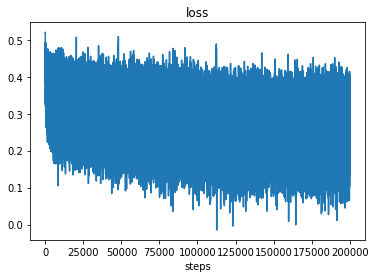

In [73]:
#Plot the loss
plt.plot(lossi)
plt.title('loss')
plt.xlabel('steps')
plt.show()

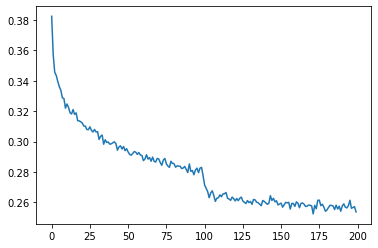

In [74]:
#averaged loss to remove some noise
plt.plot(torch.tensor(lossi).view(-1,1000).mean(dim=1))

In [75]:
#first we have to put the network in evaluation mode
for layer in model.layers:
    if isinstance(layer, BatchNorm1d):
      layer.training = False

In [76]:
# training loss
@torch.no_grad()
def split_loss(split):
  x,y = { 
      'train': (Xtr, Ytr),
      'val': (Xdev,Ydev),
      'test': (Xte,Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
  
split_loss('train')
split_loss('test')

train 1.7820684909820557
test 1.9864420890808105


In [77]:
for _ in range(20):
  out = []
  context = [0] * block_size #starting context window ... (1,block_size)
  while True:
    logits = model(torch.tensor([context])) #(batch_size, block_size, n_embed), embeds characters into vector space
    probs = F.softmax(logits,dim=1) # get the output distribution on the characters
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:]+[ix] #shifts the context window to the right one character (now includes ix)
    out.append(ix)
    if ix == 0: #terminate at character '.'
      break
  print(''.join(i_to_s[i] for i in out))

brallin.
travole.
izabella.
deilene.
evelina.
jaleah.
arthonia.
liandra.
ephreya.
leiah.
daysus.
leanthamide.
afdi.
janniel.
kaetum.
eliannyn.
auden.
fitzalia.
ash.
sofia.
